# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [18]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import types as t
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [19]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

# Load Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [20]:
# df = spark.read.json("data/sparkify_log_small.json")
df = spark.read.json("mini_sparkify_event_data.json")

In [27]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [28]:
# since we are interested in predicting user churn, the 'guests'
# need to be removed
df = df.filter(df.auth != "Guest")
# the size of the dataset
print((df.count(), len(df.columns)))

(286403, 18)


In [29]:
# show percent nulls
# because 'artist','length','song' have so many missing values I will not use them
df.select(
    [
        ( (F.count(F.when(F.isnull(c), c)) / F.count(c)) * 100 ) \
            .alias(c) for c in df.columns
    ]
).show(vertical=True)

-RECORD 0--------------------------
 artist        | 25.55587704070002 
 auth          | 0.0               
 firstName     | 2.965623359721593 
 gender        | 2.965623359721593 
 itemInSession | 0.0               
 lastName      | 2.965623359721593 
 length        | 25.55587704070002 
 level         | 0.0               
 location      | 2.965623359721593 
 method        | 0.0               
 page          | 0.0               
 registration  | 2.965623359721593 
 sessionId     | 0.0               
 song          | 25.55587704070002 
 status        | 0.0               
 ts            | 0.0               
 userAgent     | 2.965623359721593 
 userId        | 0.0               



In [30]:
# show distinct values for each column and display vertically
df.agg(*(F.countDistinct(c).alias(c) for c in df.columns)).show(vertical=True)

-RECORD 0---------------
 artist        | 17655  
 auth          | 3      
 firstName     | 189    
 gender        | 2      
 itemInSession | 1322   
 lastName      | 173    
 length        | 14865  
 level         | 2      
 location      | 114    
 method        | 2      
 page          | 20     
 registration  | 225    
 sessionId     | 2353   
 song          | 58480  
 status        | 3      
 ts            | 277359 
 userAgent     | 56     
 userId        | 226    



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [31]:
# this is a binary, indicator column to be used to predict churn
# may also look at incorporating 'downgrade'
df = df.withColumn(
    'churn',
    F.when((F.col('page') =='Cancellation Confirmation'), 1) \
    .otherwise(0)
)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [10]:
# users who have a cancellation value of 1
users_who_quit = df.filter(df.churn==1) \
    .select(df.userId) \
    .dropDuplicates()

# users who have a cancellation value of 0
users_who_stayed = df.filter(df.churn==0) \
    .select(df.userId) \
    .dropDuplicates()

# examine their lengths
users_who_quit.count(), users_who_stayed.count(), ( users_who_quit.count() / (users_who_quit.count() + users_who_stayed.count())) * 100

(52, 226, 0.18705035971223022)

In [32]:
# are cancellation rates the same between free and paid users? 
churn_table = df.select("level","churn","userId") \
    .dropDuplicates() \
    .groupBy(F.col('level'),F.col('churn')) \
    .count() \
    .withColumnRenamed('count','user_count')

churn_table.show()

+-----+-----+----------+
|level|churn|user_count|
+-----+-----+----------+
| paid|    0|       166|
| free|    0|       196|
| paid|    1|        31|
| free|    1|        21|
+-----+-----+----------+



In [90]:
# 16% of paid and 10% of free users churned
( 31 / ( 166 + 31)) * 100, ( 21 / ( 196 + 21)) * 100

(15.736040609137056, 9.67741935483871)

In [34]:
# are cancellation rates the same between free and paid users? 
churn_table = df.select("gender","churn","userId") \
    .dropDuplicates() \
    .groupBy(F.col('gender'),F.col('churn')) \
    .count() \
    .withColumnRenamed('count','user_count')

churn_table.show()

+------+-----+----------+
|gender|churn|user_count|
+------+-----+----------+
|     M|    1|        32|
|     F|    0|       104|
|     F|    1|        20|
|     M|    0|       121|
|  null|    0|         1|
+------+-----+----------+



# Feature Engineering

The goal is to predict behavior at the user level--specifically if the user 'churns' or not. 

Ideas for features are: 
1. Cumulative Totals Per User: 
    - Add Friends
    - Add to Playlist
    - Roll Advertisement
    - Error
    - Login / Logout
    - Thumbs Up / Thumbs Down
    - Submit Upgrade / Submit Downgrade

2. Location: 
    - City
    - State
    
3. userAgent: 
    - browser
    - os 
    - brand
    
4. Time: 
    - Avg. Length of Session
    - Time Spent as Free / Paid Level
    - Time User spent on Sparkify
    
5. Gender of User

#### 1. Cumulative Totals Per User DataFrame

In [130]:
# Cumulative Totals of Page Per User
page_list = ["Add Friend", "Add to Playlist", "Logout", "Thumbs Up", 
             "Thumbs Down", "Error", "Roll Advert", "Help"]

user_page = df.select("userId","page") \
    .filter(F.col("page").isin(page_list)) \
    .groupBy("userId") \
    .pivot("page") \
    .agg(F.count("page").alias("page_count"))

user_page.show()

+------+----------+---------------+-----+----+------+-----------+-----------+---------+
|userId|Add Friend|Add to Playlist|Error|Help|Logout|Roll Advert|Thumbs Down|Thumbs Up|
+------+----------+---------------+-----+----+------+-----------+-----------+---------+
|200002|         4|              8| null|   2|     5|          7|          6|       21|
|100010|         4|              7| null|   2|     5|         52|          5|       17|
|   125|      null|           null| null|null|  null|          1|       null|     null|
|    51|        28|             52|    1|  12|    24|       null|         21|      100|
|     7|         1|              5|    1|   1|     3|         16|          1|        7|
|   124|        74|            118|    6|  23|    59|          4|         41|      171|
|    54|        33|             72|    1|  17|    36|         47|         29|      163|
|    15|        31|             59|    2|   8|    27|          1|         14|       81|
|   155|        11|             

#### 2. Location DataFrame

In [118]:
# split the 'location' field into 'city' and 'state fields'
user_location = df.withColumn('city', F.split(df['location'], ',').getItem(0)) \
    .withColumn('state', F.split(df['location'], ',').getItem(1)) \
    .select("userId","city","state") \
    .dropDuplicates()

user_location.show()

+------+--------------------+------------+
|userId|                city|       state|
+------+--------------------+------------+
|    13|Philadelphia-Camd...| PA-NJ-DE-MD|
|   124|  Vineland-Bridgeton|          NJ|
|300017|               Ionia|          MI|
|    67|Sacramento--Rosev...|          CA|
|    91|   New Haven-Milford|          CT|
|   136|Charlotte-Concord...|       NC-SC|
|200021|Detroit-Warren-De...|          MI|
|300005|             Roanoke|          VA|
|    20|Miami-Fort Lauder...|          FL|
|   151|Washington-Arling...| DC-VA-MD-WV|
|    95|Phoenix-Mesa-Scot...|          AZ|
|   104|            Billings|          MT|
|300008|          Cookeville|          TN|
|    62|Houston-The Woodl...|          TX|
|300009|           St. Louis|       MO-IL|
|    24|                Troy|          AL|
|    81|Philadelphia-Camd...| PA-NJ-DE-MD|
|    93|Allentown-Bethleh...|       PA-NJ|
|   114|Las Vegas-Henders...|          NV|
|    99|   New Haven-Milford|          CT|
+------+---

#### 3. Browser / Device DataFrame

In [119]:
# create browser, os, brand from userAgent
df = df.withColumn('browser', F.split(df['userAgent'], '\(').getItem(0)) \
    .withColumn('temp', F.split(df['userAgent'], '\(').getItem(1)) 

df = df.withColumn('os', F.split(df['temp'], ';').getItem(0)) \
    .withColumn('brand', F.split(df['temp'], ';').getItem(1))

user_browser = df.select("userId","browser","os","brand").dropDuplicates()

user_browser.show()

+------+-------------+--------------------+--------------------+
|userId|      browser|                  os|               brand|
+------+-------------+--------------------+--------------------+
|    74|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|    14| Mozilla/5.0 |           Macintosh| Intel Mac OS X 10.9|
|100010|"Mozilla/5.0 |              iPhone| CPU iPhone OS 7_...|
|    59| Mozilla/5.0 |      Windows NT 6.1|               WOW64|
|   132|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|   153|"Mozilla/5.0 |      Windows NT 6.1| WOW64) AppleWebK...|
|    83|"Mozilla/5.0 |                 X11| Linux x86_64) Ap...|
|100014|"Mozilla/5.0 |      Windows NT 6.1| WOW64) AppleWebK...|
|    96|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|200023|"Mozilla/5.0 |      Windows NT 6.3| WOW64) AppleWebK...|
|200006|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|    28| Mozilla/5.0 |      Windows NT 6.1|               WOW64|
|    70|"Mozilla/5.0 |   

#### 4. Time DataFrames

In [120]:
# create window partition
w = Window.partitionBy("userId","sessionId").orderBy("sessionId")
# calculate session duration ( per user ) in HOURS
user_sess_dur = df.select("userId","sessionId","ts") \
    .withColumn("max_ts", F.max('ts').over(w)) \
    .withColumn("min_ts", F.min('ts').over(w)) \
    .withColumn("tsDiff", ( F.col('max_ts') - F.col('min_ts')) / ( 1000 * 3600 )) \
    .select("userId","sessionId","tsDiff") \
    .dropDuplicates() \
    .groupBy("userId") \
    .agg(F.round(F.avg("tsDiff"),1).alias("avgSessionHours"))

user_sess_dur.show()

+------+---------------+
|userId|avgSessionHours|
+------+---------------+
|100010|            2.6|
|200002|            4.4|
|   125|            0.5|
|    51|           14.5|
|   124|            9.6|
|     7|            1.5|
|    54|            5.4|
|    15|            8.8|
|   155|            9.1|
|100014|            3.1|
|   132|            8.3|
|   154|            1.8|
|   101|           13.6|
|    11|            2.7|
|300017|            3.9|
|   138|            9.4|
|    29|            6.1|
|    69|            8.8|
|100021|            3.6|
|    42|            5.5|
+------+---------------+
only showing top 20 rows



In [121]:
# create window partition
w = Window.partitionBy("userId").orderBy("userId")
# calculate total time used
user_days = df.select("userId","ts") \
    .withColumn("max_ts", F.max('ts').over(w)) \
    .withColumn("min_ts", F.min('ts').over(w)) \
    .withColumn("daysUsed", F.round(( F.col('max_ts') - F.col('min_ts') ) / ( 1000 * 3600 * 24), 1)) \
    .select("userId", "daysUsed") \
    .dropDuplicates()

user_days.show()

+------+--------+
|userId|daysUsed|
+------+--------+
|100010|    44.2|
|200002|    45.5|
|   125|     0.0|
|   124|    60.0|
|    51|    15.8|
|     7|    50.8|
|    15|    54.8|
|    54|    42.8|
|   155|    25.8|
|100014|    41.2|
|   132|    50.5|
|   154|    25.0|
|   101|    15.9|
|    11|    53.2|
|   138|    56.1|
|300017|    59.1|
|100021|    45.5|
|    29|    43.3|
|    69|    51.0|
|   112|    56.9|
+------+--------+
only showing top 20 rows



In [122]:
# create window partition
w = Window.partitionBy("userId", "level").orderBy("userId")

user_level = df.select("userId", "level", "ts") \
    .withColumn("max_ts", F.max("ts").over(w)) \
    .withColumn("min_ts", F.min("ts").over(w)) \
    .withColumn("daysAs", (F.col("max_ts") - F.col("min_ts")) / (1000 * 3600 * 24)) \
    .select("userId","level","daysAs") \
    .dropDuplicates() \
    .groupBy("userId") \
    .pivot("level") \
    .agg(F.round(F.avg("daysAs"),1))

user_level.show()

+------+----+----+
|userId|free|paid|
+------+----+----+
|200002|16.9|28.6|
|100010|44.2|null|
|   125| 0.0|null|
|     7|50.8|null|
|   124|null|60.0|
|    51|null|15.8|
|    54|14.0|42.8|
|    15|null|54.8|
|   155| 6.4|19.4|
|   132| 0.1|50.4|
|   154|25.0|null|
|100014|null|41.2|
|    11|42.5|47.1|
|   101| 1.7|14.2|
|300017|null|59.1|
|   138|16.6|39.5|
|100021|45.5|null|
|    29| 6.7|36.6|
|    69| 4.1|46.9|
|   112|56.9|null|
+------+----+----+
only showing top 20 rows



#### 5. Gender and Churn DataFrame

In [123]:
# create churn table
user_churn = df.select("userId", "gender","churn") \
    .withColumnRenamed("churn","label") \
    .dropDuplicates()

user_churn.show()

+------+------+-----+
|userId|gender|label|
+------+------+-----+
|   153|     M|    0|
|   111|     F|    0|
|   156|     M|    0|
|100005|     M|    1|
|    11|     F|    0|
|   125|     M|    1|
|200022|     M|    0|
|300020|     F|    0|
|    32|     M|    0|
|   150|     M|    0|
|300015|     M|    0|
|   148|     M|    0|
|200017|     M|    0|
|200021|     F|    1|
|    26|     M|    0|
|200018|     M|    0|
|   115|     F|    0|
|300013|     M|    0|
|    29|     M|    1|
|200023|     F|    0|
+------+------+-----+
only showing top 20 rows



#### Join Tables Together

In [131]:
# join all the tables together
user_data = user_churn.join(user_page, ['userId'], "left") \
    .join(user_location, ['userId'], "left") \
    .join(user_browser,['userId'], "left") \
    .join(user_sess_dur, ['userId'], "left") \
    .join(user_days, ['userId'], "left") \
    .join(user_level, ['userId'], "left") \
    .drop("userId")

user_data.show()

+------+-----+----------+---------------+-----+----+------+-----------+-----------+---------+--------------------+---------+-------------+--------------+--------------------+---------------+--------+----+----+
|gender|label|Add Friend|Add to Playlist|Error|Help|Logout|Roll Advert|Thumbs Down|Thumbs Up|                city|    state|      browser|            os|               brand|avgSessionHours|daysUsed|free|paid|
+------+-----+----------+---------------+-----+----+------+-----------+-----------+---------+--------------------+---------+-------------+--------------+--------------------+---------------+--------+----+----+
|     F|    0|         4|              7| null|   2|     5|         52|          5|       17|Bridgeport-Stamfo...|       CT|"Mozilla/5.0 |        iPhone| CPU iPhone OS 7_...|            2.6|    44.2|44.2|null|
|     M|    0|         4|              8| null|   2|     5|          7|          6|       21|Chicago-Napervill...| IL-IN-WI|"Mozilla/5.0 |        iPhone| CPU iP

#### Fill nulls with 0 / 'missing'

I had difficulty with the imputer in my pipeline. Perhaps it was related to the stringIndexer. 

In [135]:
numeric_cols = user_page.columns[1:] + user_sess_dur.columns[1:] + user_days.columns[1:] + user_level.columns[1:]
impute_numeric = { i : 0 for i in numeric_cols }
user_data = user_data.fillna(impute_numeric)

In [141]:
categ_cols = user_location.columns[1:] + user_browser.columns[1:] + ['gender']
impute_categ = { i : 'missing' for i in categ_cols }
user_data = user_data.fillna(impute_categ)

In [143]:
user_data.select(
    [
        ( (F.count(F.when(F.isnull(c), c)) / F.count(c)) * 100 ) \
            .alias(c) for c in user_data.columns
    ]
).show(vertical=True)

-RECORD 0--------------
 gender          | 0.0 
 label           | 0.0 
 Add Friend      | 0.0 
 Add to Playlist | 0.0 
 Error           | 0.0 
 Help            | 0.0 
 Logout          | 0.0 
 Roll Advert     | 0.0 
 Thumbs Down     | 0.0 
 Thumbs Up       | 0.0 
 city            | 0.0 
 state           | 0.0 
 browser         | 0.0 
 os              | 0.0 
 brand           | 0.0 
 avgSessionHours | 0.0 
 daysUsed        | 0.0 
 free            | 0.0 
 paid            | 0.0 



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Columns Used: 

#### Old Pipeline

In [26]:
categ_pipeline = Pipeline(stages=[
    StringIndexer(inputCol="city",outputCol="cityIndex", handleInvalid="skip"),
    StringIndexer(inputCol="state",outputCol="stateIndex", handleInvalid="skip"),
    StringIndexer(inputCol="browser",outputCol="osIndex", handleInvalid="skip"),
    StringIndexer(inputCol="os",outputCol="browserIndex", handleInvalid="skip"),
    StringIndexer(inputCol="brand",outputCol="brandIndex", handleInvalid="skip"),
    VectorAssembler(
        inputCols=["cityIndex","stateIndex","osIndex","browserIndex","brandIndex"], 
        outputCol="categ_features"
    )
])

# create list of numeric columns
numeric_cols = user_page_df.columns[1:] + user_level.columns[1:]
out_numeric_cols = [ n + '_imp' for n in numeric_cols ]
# create pipeline
numer_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=numeric_cols, outputCol="numer_features")
])

# unite pipelines
final_pipeline = Pipeline(stages=[
    categ_pipeline,
    numer_pipeline,
    VectorAssembler(
        inputCols=["categ_features","numer_features"],
        outputCol="features"
    ),
    LogisticRegression(maxIter=10)
])


#### New Pipeline (Just Numeric)

In [145]:
# this pipeline will consider numeric features only
numer_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=numeric_cols, outputCol='features'), 
    LogisticRegression(maxIter=10, regParam=0.01)
])

In [146]:
#fit the pipeline to our dataframe
pipelineModel = numer_pipeline.fit(user_data)
#transform the dataframe
# transformed_data = pipelineModel.transform(user_data)

In [147]:
pipelineModel.stages[-1].summary.accuracy

0.8129496402877698

In [148]:
pipelineModel.stages[-1].summary.areaUnderROC

0.7994383934649422

In [154]:
# save roc data
roc_df = pipelineModel.stages[-1].summary.roc
# convert to pandas

In [155]:
import pandas as pd
pandasDF = roc_df.toPandas()
# create scatterplot

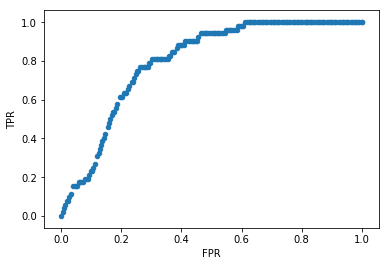

In [156]:
%matplotlib inline
pandasDF.plot.scatter(x='FPR',y='TPR')

In [150]:
import numpy as np
coeffs = pipelineModel.stages[-1].coefficientMatrix.toArray()

In [157]:
# it looks like the more advertisements, more thumbs down the more likely the person is to churn
np.exp(coeffs)

array([[ 0.98584538,  1.00394802,  0.89263198,  0.99561462,  1.00218743,
         1.0230768 ,  1.0314619 ,  0.99927293,  0.9868398 ,  0.9747712 ,
         0.9638969 ,  0.98407986]])

# Cross-Validate

In [23]:
paramGrid = ParamGridBuilder() \
    .addGrid(LogisticRegression.regParam, [0.1, 0.05, 0.01]) \
    .build()

In [32]:
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC'),
                          numFolds=5) 

In [33]:
cvModel = crossval.fit(user_data)

In [34]:
# certainly looks like the regParam is fine at 0.1
cvModel.avgMetrics

[0.7880498487020224, 0.7880498487020224, 0.7880498487020224]

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.